In [60]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['multilabel-bird-species-classification-nips2013', 'bird-songs-pad-and-resize-spectrogram']


In [61]:
! tar xf ../input/bird-songs-pad-and-resize-spectrogram/spectrograms_resized.tar.bz2

In [62]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import matplotlib.pyplot as plt

from fastai.vision import *

In [63]:
data_dir = Path('../input')
label_dir = data_dir/'multilabel-bird-species-classification-nips2013/nips4b_bird_challenge_train_labels/NIPS4B_BIRD_CHALLENGE_TRAIN_LABELS'
spect_dir = Path('./spectrograms_resized')

## Clean up labels

In [64]:
df = pd.read_csv(label_dir/'nips4b_birdchallenge_train_labels.csv', skiprows=[0, 2])
df.tail()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,class name >,Aegcau_call,Alaarv_song,Anttri_song,Butbut_call,Carcan_call,Carcan_song,Carcar_call,Carcar_song,Cerbra_call,Cerbra_song,Cetcet_song,Chlchl_call,Cicatr_song,Cicorn_song,Cisjun_song,Colpal_song,Corcor_call,Denmaj_call,Denmaj_drum,Embcir_call,Embcir_song,Erirub_call,Erirub_song,Fricoe_call,Fricoe_song,Galcri_call,Galcri_song,Galthe_call,Galthe_song,Gargla_call,Hirrus_call,Jyntor_song,Lopcri_call,Loxcur_call,Lularb_song,Lusmeg_call,...,Parmaj_song,Pasdom_call,Pelgra_call,Petpet_call,Petpet_song,Phofem_song,Phycol_call,Phycol_song,Picpic_call,Plaaff_song,Plasab_song,Poepal_call,Poepal_song,Prumod_song,Ptehey_song,Pyrpyr_call,Regign_call,Regign_song,Serser_call,Serser_song,Siteur_call,Siteur_song,Strdec_song,Strtur_song,Stuvul_call,Sylatr_call,Sylatr_song,Sylcan_call,Sylcan_song,Sylmel_call,Sylmel_song,Sylund_call,Sylund_song,Tetpyg_song,Tibtom_song,Trotro_song,Turmer_call,Turmer_song,Turphi_call,Turphi_song
683,nips4b_birds_trainfile684.wav,1,NaN,­,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
684,nips4b_birds_trainfile685.wav,2,NaN,­,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
685,nips4b_birds_trainfile686.wav,3,NaN,­,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
686,nips4b_birds_trainfile687.wav,3,NaN,­,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
687,NaN,TOTAL,100.0,­,11.0,15.0,10.0,10.0,16.0,16.0,16.0,11.0,13.0,9.0,17.0,13.0,12.0,10.0,10.0,7.0,8.0,9.0,10.0,13.0,14.0,16.0,20.0,18.0,14.0,17.0,11.0,10.0,14.0,9.0,8.0,8.0,12.0,12.0,18.0,18.0,...,14.0,20.0,10.0,14.0,17.0,17.0,12.0,17.0,10.0,17.0,13.0,9.0,9.0,13.0,17.0,13.0,17.0,16.0,10.0,18.0,7.0,18.0,8.0,11.0,12.0,10.0,11.0,16.0,20.0,17.0,12.0,10.0,15.0,12.0,12.0,12.0,18.0,18.0,8.0,17.0


In [65]:
df.drop(df.columns[[1, 3]],axis=1,inplace=True)  # drop colums 1 and 3
df.rename(columns={df.columns[0]:'file', df.columns[1]:'EMPTY'}, inplace=True)  # add 'EMPTY' label
df = df[:-1]  # drop last row
df.fillna(0, inplace=True)  # fill all the NaN's
df = df.astype('int32', errors='ignore') # make integer labels
df['file'] = df['file'].apply(lambda fn: str(Path(fn).with_suffix(''))) # drop .wav in the filenames

df.tail()

,file,EMPTY,Aegcau_call,Alaarv_song,Anttri_song,Butbut_call,Carcan_call,Carcan_song,Carcar_call,Carcar_song,Cerbra_call,Cerbra_song,Cetcet_song,Chlchl_call,Cicatr_song,Cicorn_song,Cisjun_song,Colpal_song,Corcor_call,Denmaj_call,Denmaj_drum,Embcir_call,Embcir_song,Erirub_call,Erirub_song,Fricoe_call,Fricoe_song,Galcri_call,Galcri_song,Galthe_call,Galthe_song,Gargla_call,Hirrus_call,Jyntor_song,Lopcri_call,Loxcur_call,Lularb_song,Lusmeg_call,Lusmeg_song,Lyrple_song,...,Parmaj_song,Pasdom_call,Pelgra_call,Petpet_call,Petpet_song,Phofem_song,Phycol_call,Phycol_song,Picpic_call,Plaaff_song,Plasab_song,Poepal_call,Poepal_song,Prumod_song,Ptehey_song,Pyrpyr_call,Regign_call,Regign_song,Serser_call,Serser_song,Siteur_call,Siteur_song,Strdec_song,Strtur_song,Stuvul_call,Sylatr_call,Sylatr_song,Sylcan_call,Sylcan_song,Sylmel_call,Sylmel_song,Sylund_call,Sylund_song,Tetpyg_song,Tibtom_song,Trotro_song,Turmer_call,Turmer_song,Turphi_call,Turphi_song
682,nips4b_birds_trainfile683,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
683,nips4b_birds_trainfile684,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
684,nips4b_birds_trainfile685,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
685,nips4b_birds_trainfile686,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
686,nips4b_birds_trainfile687,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Load dataset

In [66]:
np.random.seed(42)
src = (ImageList.from_df(df, spect_dir, folder='train', suffix='.png')
                .split_by_rand_pct(0.2)
                .label_from_df(cols=df.columns[1:].tolist()))

Don't do flips, it doens't make sense for spectrograms:

In [67]:
tfms = get_transforms(do_flip=False, max_rotate=None, max_warp=None)
data = (src.transform(tfms, size=128)
        .databunch(num_workers=0).normalize(imagenet_stats))

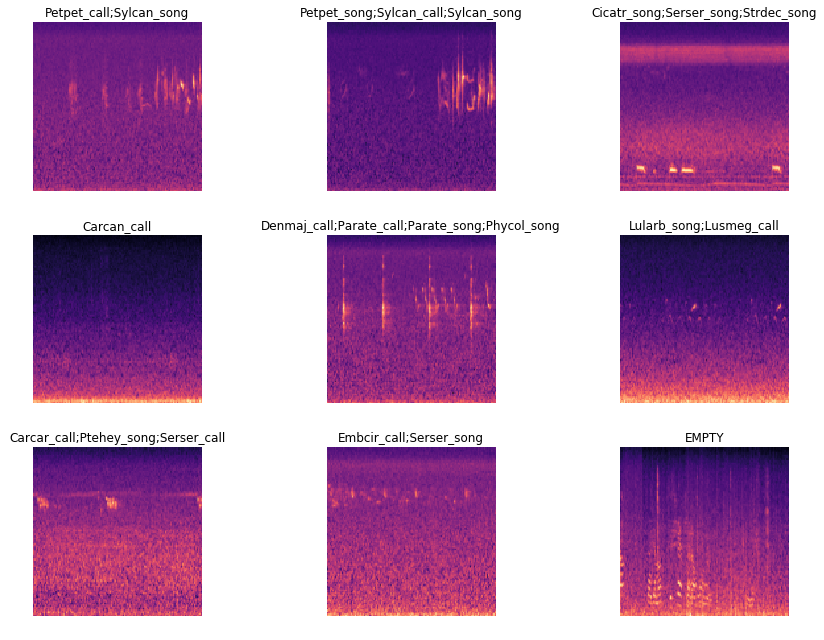

In [68]:
data.show_batch(rows=3, figsize=(12,9), ds_type=DatasetType.Valid)

## Train with size 128

In [69]:
arch = models.resnet50
acc_02 = partial(accuracy_thresh, thresh=0.2)
learn = cnn_learner(data, arch, metrics=acc_02, path='.')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-02


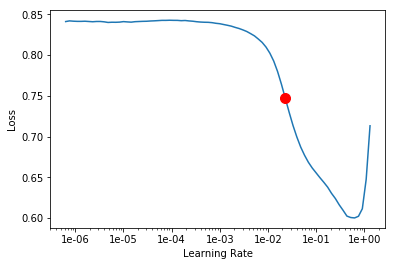

In [70]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [71]:
lr = 2.29E-02
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.797722,0.647212,0.071666,00:10
1,0.524980,0.122708,0.979181,00:10
2,0.375540,0.137662,0.975863,00:10
3,0.293553,0.103782,0.973540,00:10
4,0.240102,0.098885,0.970803,00:11


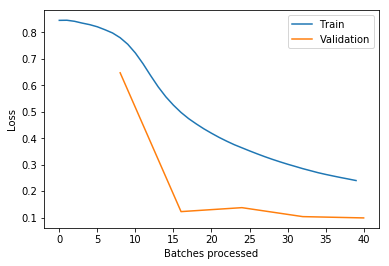

In [72]:
learn.recorder.plot_losses()

In [73]:
learn.save('stage-1-rn50', return_path=True)

PosixPath('models/stage-1-rn50.pth')

Unfreeze and fine tune:

In [74]:
# learn.load('stage-1-rn50')

In [75]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06


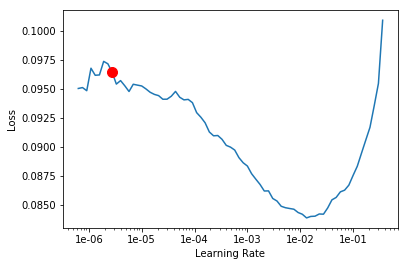

In [76]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [77]:
learn.fit_one_cycle(5, slice(3.02E-03, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.097558,0.246177,0.972711,00:11
1,0.093704,6.212976,0.951477,00:11
2,0.089053,0.783576,0.971550,00:12
3,0.084302,0.086603,0.977356,00:12
4,0.079733,0.071270,0.979512,00:12


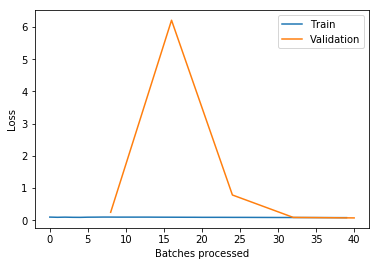

In [78]:
learn.recorder.plot_losses()

In [79]:
learn.save('stage-2-rn50')

## Train with size 256

Replace data in learner with size 256 images

In [80]:
data_256 = (src.transform(tfms, size=256)
            .databunch(num_workers=0).normalize(imagenet_stats))

learn.data = data_256
learn.data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [81]:
learn.freeze()

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
lr = 5E-03
learn.fit_one_cycle(5, slice(lr))

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-1-256-rn50')

Unfreeze and fine tune:

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(5, slice(1.58E-06, lr/5))

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-2-256-rn50')

Run some more epochs

In [ ]:
learn.fit_one_cycle(5, slice(1.58E-06, lr/5))

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-2-256-rn50-10e')

In [ ]:
learn.export()

## Prediction and submission

In [ ]:
test = ImageList.from_folder(spect_dir/'test/')
len(test)

In [ ]:
predictor = load_learner('.', test=test, num_workers=0)
preds, _ = predictor.get_preds(ds_type=DatasetType.Test)
fpreds = preds[:, 1:].reshape(-1, )

In [ ]:
import itertools
names = [f.stem for f in predictor.data.test_ds.items]
fnames = [x + '.wav_classnumber_' + str(i) for x in names for i in range(1, len(data.classes))]

In [ ]:
test_df = pd.DataFrame({'ID':fnames, 'Probability':fpreds}, columns=['ID', 'Probability'])
test_df.to_csv('submission.csv', index=False)

In [ ]:
! rm -r $spect_dir